# Loading Libraries

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

# Analyzing

In [16]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row = 48
col = 48
classes = len(os.listdir('../input/fer2013/train/'))

In [17]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
surprise folder contains		 3171 image
fear folder contains		 4097 image
angry folder contains		 3995 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
disgust folder contains		 436 image
happy folder contains		 7215 image

Test Set :
surprise folder contains		 831 images
fear folder contains		 1024 images
angry folder contains		 958 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
disgust folder contains		 111 images
happy folder contains		 1774 images


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


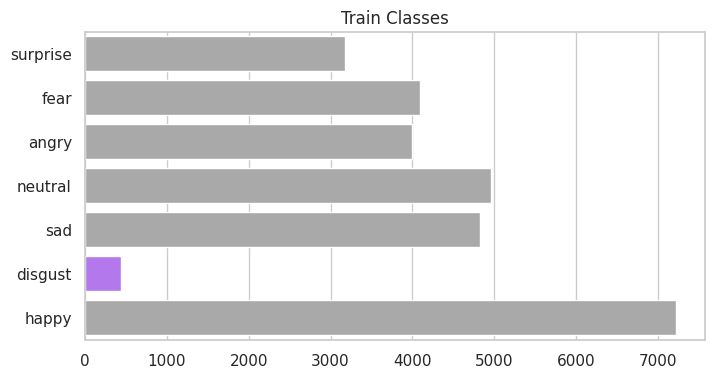

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


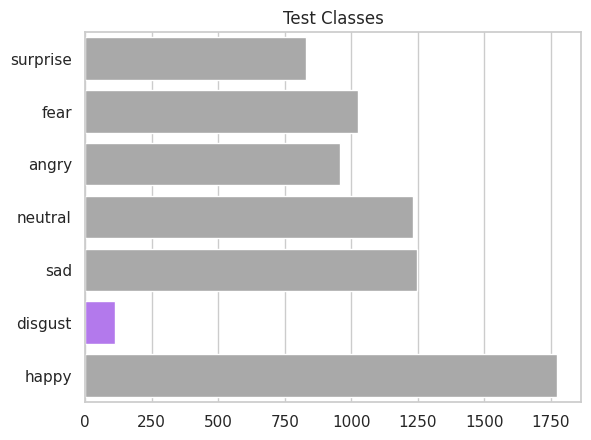

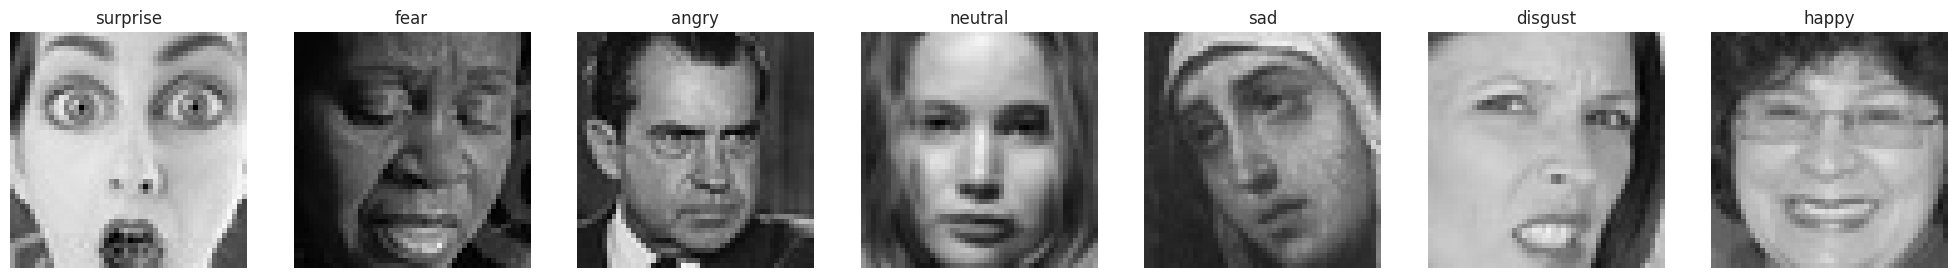

In [18]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

# Preprocessing

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Model

In [23]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [24]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,116,743 (122.52 MB)

 Trainable params: 32,116,103 (122.51 MB)

 Non-trainable params: 640 (2.50 KB)

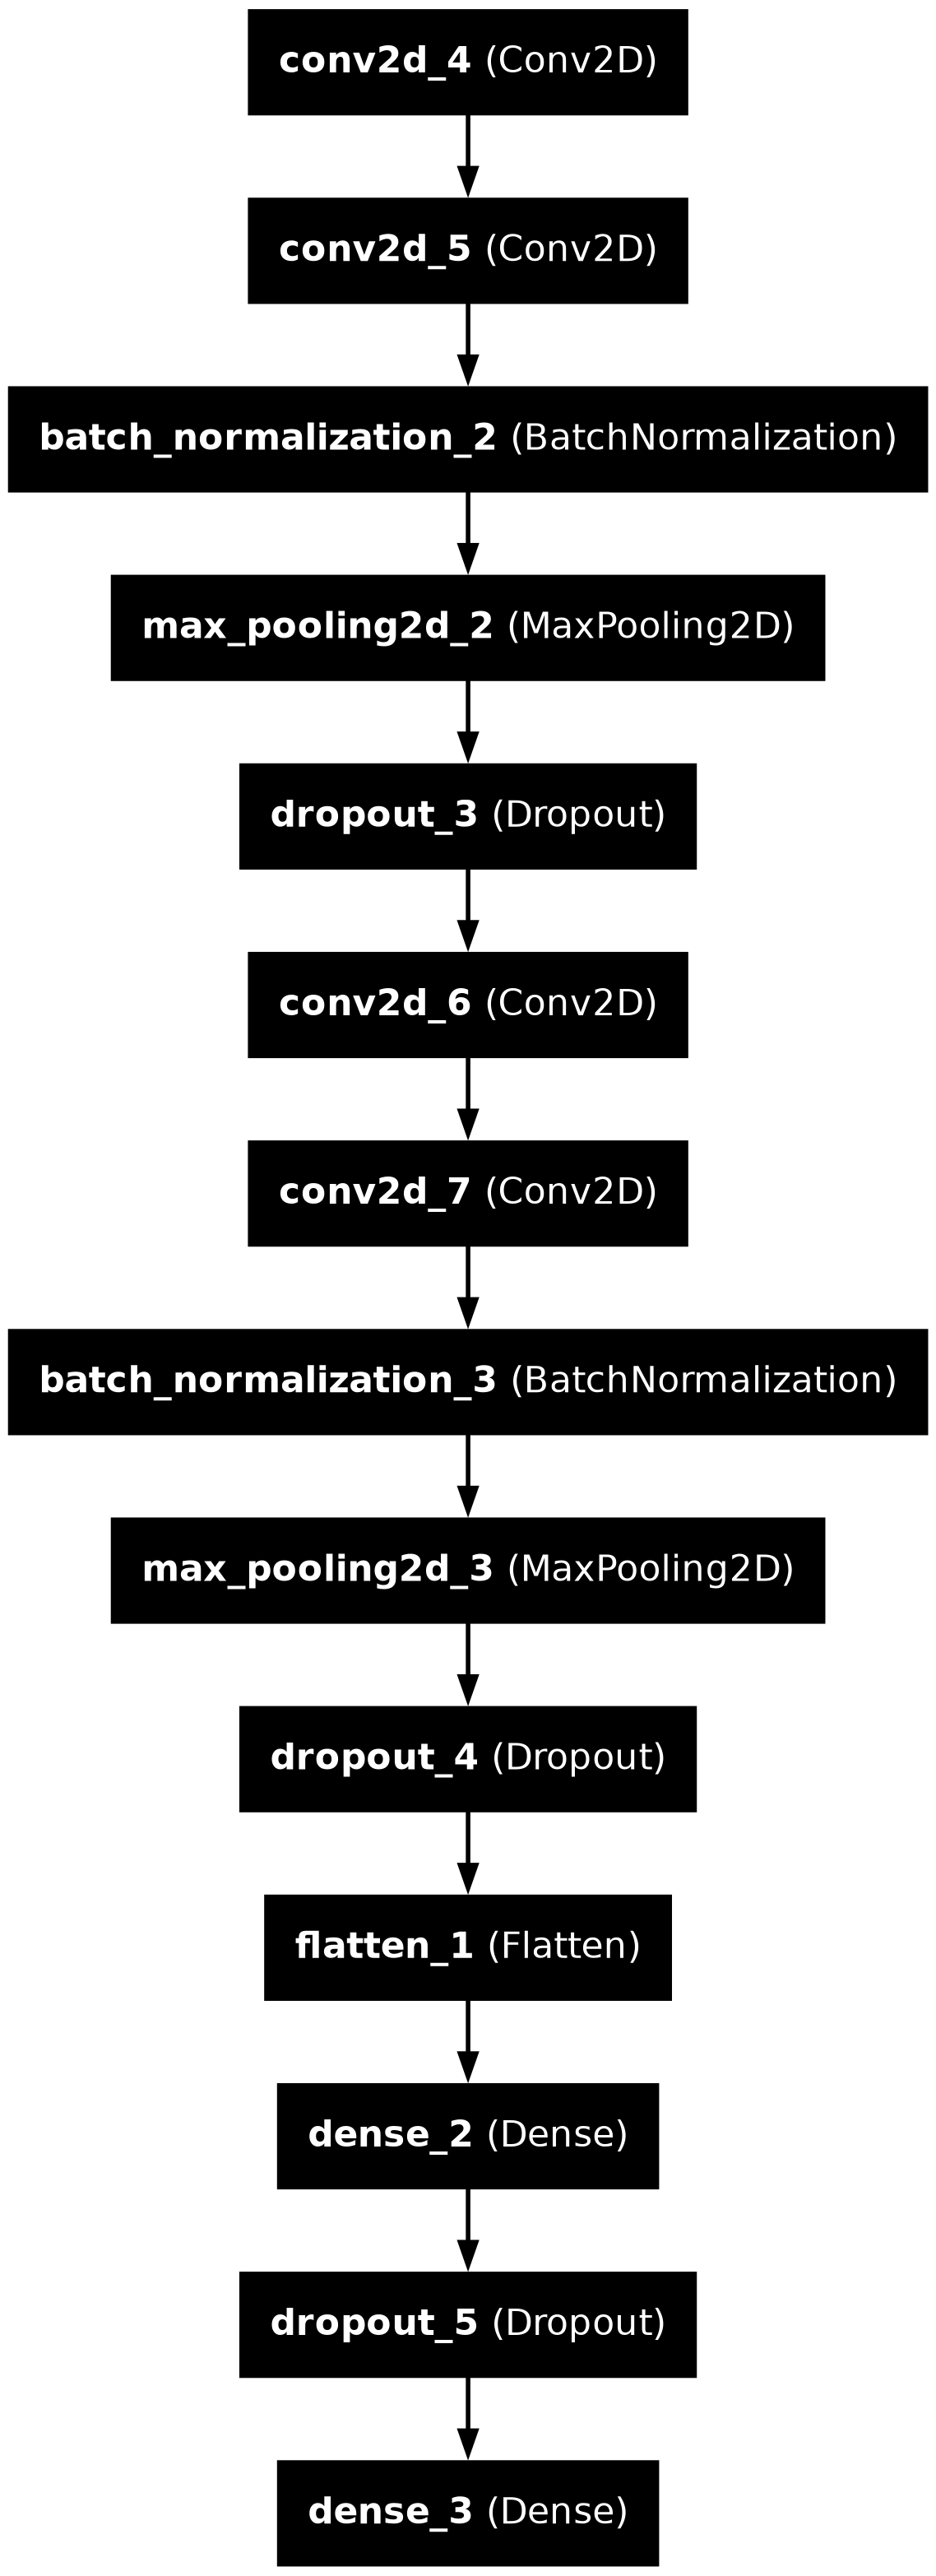

In [25]:
plot_model(fernet, show_layer_names=True)

# Checkpoint

In [29]:
chk_path = 'ferNet.keras'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [30]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=150,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733860383.319516     195 service.cc:145] XLA service 0x7b7bcc005cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733860383.319597     195 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:29:59 12s/step - accuracy: 0.2344 - loss: 7.8088

I0000 00:00:1733860390.920627     195 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.2476 - loss: 4.9685
Epoch 1: val_accuracy improved from inf to 0.28195, saving model to ferNet.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 174s 361ms/step - accuracy: 0.2476 - loss: 4.9669 - val_accuracy: 0.2819 - val_loss: 5.3372 - learning_rate: 1.0000e-04
Epoch 2/150
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3281 - loss: 3.7586

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.28195
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3281 - loss: 3.7586 - val_accuracy: 0.7000 - val_loss: 3.5107 - learning_rate: 1.0000e-04
Epoch 3/150
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3113 - loss: 3.5983
Epoch 3: val_accuracy did not improve from 0.28195
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.3113 - loss: 3.5980 - val_accuracy: 0.3929 - val_loss: 3.1483 - learning_rate: 1.0000e-04
Epoch 4/150
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4688 - loss: 3.0674
Epoch 4: val_accuracy did not improve from 0.28195
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.4688 - loss: 3.0674 - val_accuracy: 0.3000 - val_loss: 3.3164 - learning_rate: 1.0000e-04
Epoch 5/150
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3619 - loss: 3.0346
Epoch 5: val_accuracy did not improve from 0.28195
448/448 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.3619 - loss: 3.0343 - val_accuracy: 

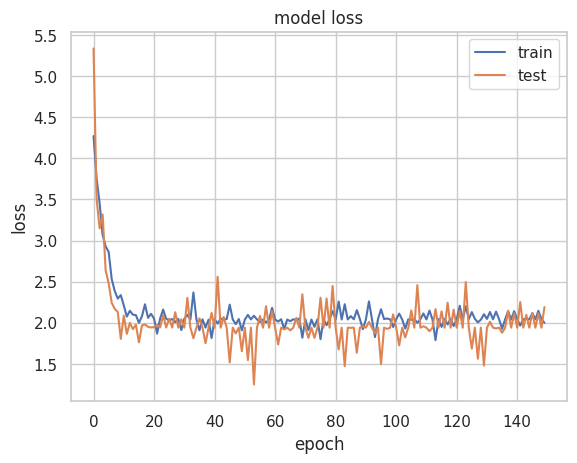

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

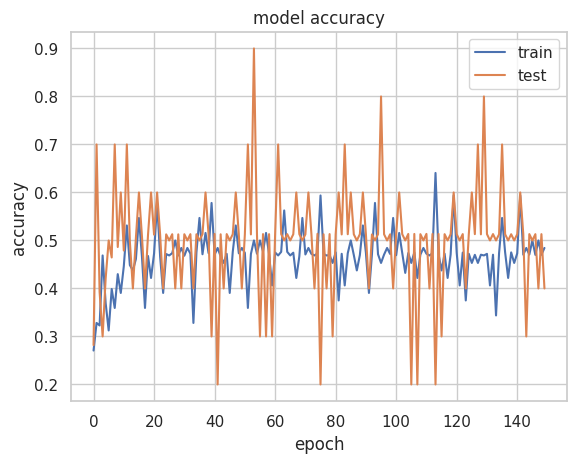

In [32]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [33]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.5007 - loss: 1.9652
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5149 - loss: 1.9403
final train accuracy = 50.39 , validation accuracy = 51.25


# Result

449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step
Confusion Matrix
[[ 454    2  234 1410  830  600  465]
 [  56    0   23  135   84   77   61]
 [ 469    1  239 1452  801  651  484]
 [ 840    2  382 2436 1503 1198  854]
 [ 587    0  289 1696 1004  794  595]
 [ 573    4  284 1674  969  762  564]
 [ 321    1  185 1082  632  545  405]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.11      0.12      3995
     disgust       0.00      0.00      0.00       436
        fear       0.15      0.06      0.08      4097
       happy       0.25      0.34      0.28      7215
     neutral       0.17      0.20      0.19      4965
         sad       0.16      0.16      0.16      4830
    surprise       0.12      0.13      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



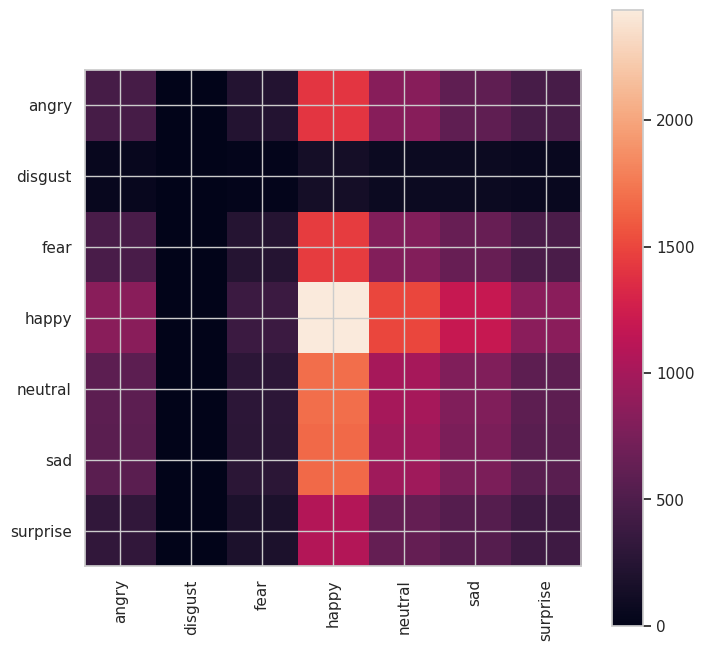

In [34]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
Confusion Matrix
[[139   0  75 288 211 116 129]
 [ 13   0  14  34  18  16  16]
 [141   1  84 338 204 123 133]
 [224   0 124 622 366 199 239]
 [166   0  85 401 259 136 186]
 [189   0  95 426 254 130 153]
 [112   1  59 299 162  86 112]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.08      0.11      1024
       happy       0.26      0.35      0.30      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.16      0.10      0.13      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.19      7178
   macro avg       0.14      0.15      0.14      7178
weighted avg       0.18      0.19      0.18      7178



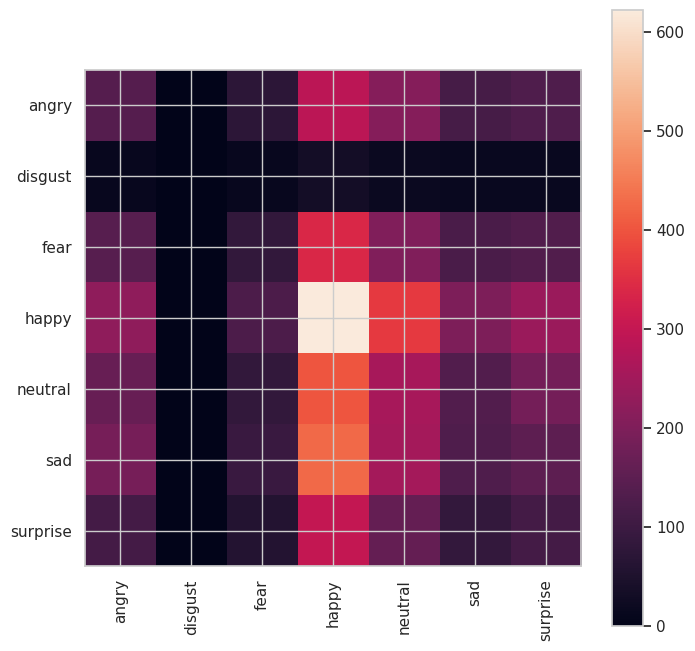

In [35]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Recommending Music

In [36]:
mood_music = pd.read_csv("../input/spotify-music-data-to-identify-the-moods/data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


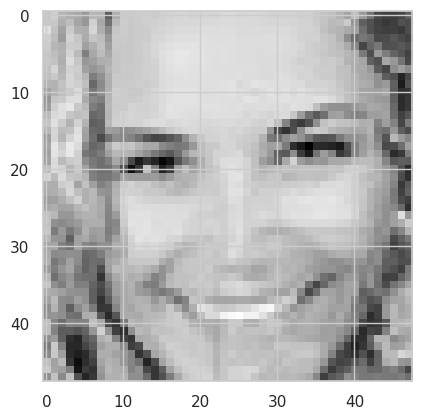

In [37]:
image = cv2.imread('../input/fer2013/test/happy/PrivateTest_10077120.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [38]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


3

In [39]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,557,The Joker,Steve Miller Band,Happy
1,115,Crazy Horses,The Osmonds,Happy
2,153,Driver's Seat,Sniff 'n' The Tears,Happy
3,369,Never Letting Go,Audien,Happy
4,516,Stuck In The Middle With You,Various Artists,Happy
